**Data Project - Stock Market Analysis**

Getting the Data

In [90]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn import neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

The Alpha Vantage API provides real-time and historical stock market data, technical indicators, cryptocurrency..

Free Tier: 5 requests/min, 500/day; premium plans available for higher limits.

Use Cases: Trading algorithms, market research, financial dashboards.

Key Features: 50+ technical indicators, stock prices, and more.

In [91]:
load_dotenv()
API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

In [ ]:
# data extract function
def fetch_stock_data(symbol, outputsize='compact'):
    base_url = 'https://www.alphavantage.co/query'
    params = {
        'function': 'TIME_SERIES_DAILY',
        'symbol': symbol,
        'apikey': API_KEY,
        'outputsize': outputsize
    }
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error fetching data: {response.status_code}")
        return None

In [ ]:
def convert_to_dataframe(json_data):
    time_series = json_data.get(f'Time Series (Daily)', {})

    df = pd.DataFrame.from_dict(time_series, orient='index')
    
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    
    df.index = pd.to_datetime(df.index)
    
    df = df.apply(pd.to_numeric)
    
    return df

In [59]:
tech_list = ['AAPL', 'GOOG', 'IBM', 'AMZN']

dataframes = {}

for symbol in tech_list:
    stock_data = fetch_stock_data(symbol=symbol, outputsize="full")
    dataframes[symbol] = convert_to_dataframe(json_data=stock_data)

In [60]:
ibm_data = dataframes['IBM']
aapl_data = dataframes['AAPL']
goog_data = dataframes['GOOG']
amzn_data = dataframes['AMZN']

In [61]:
aapl_data.shape

(6310, 5)

In [62]:
ibm_data.shape

(6310, 5)

In [63]:
goog_data.shape

(2688, 5)

In [64]:
amzn_data.shape

(6310, 5)

In [65]:
goog_data

,open,high,low,close,volume
2024-11-27,170.680,171.1400,169.67,170.82,12433371
2024-11-26,169.490,171.4950,169.43,170.62,14937478
2024-11-25,167.990,170.4600,167.40,169.43,21395652
2024-11-22,167.160,168.2645,165.71,166.57,24497042
2024-11-21,175.455,175.5800,165.31,169.24,38839431
...,...,...,...,...,...
2014-04-02,565.106,604.8300,562.19,567.00,146700
2014-04-01,558.710,568.4500,558.71,567.16,7900
2014-03-31,566.890,567.0000,556.93,556.97,10800
2014-03-28,561.200,566.4300,558.67,559.99,41100


In [66]:
ibm_data

,open,high,low,close,volume
2024-11-27,228.83,229.19,224.2700,226.92,2995121
2024-11-26,226.73,228.98,225.5115,228.83,4449543
2024-11-25,223.35,226.42,222.6500,226.13,7189260
2024-11-22,223.35,227.20,220.8900,222.97,5320740
2024-11-21,215.81,222.63,215.2701,222.40,5236434
...,...,...,...,...,...
1999-11-05,92.75,92.94,90.1900,90.25,13737600
1999-11-04,94.44,94.44,90.0000,91.56,16697600
1999-11-03,95.87,95.94,93.5000,94.37,10369100
1999-11-02,96.75,96.81,93.6900,94.81,11105400


In [67]:
ibm_data.tail()

,open,high,low,close,volume
1999-11-05,92.75,92.94,90.19,90.25,13737600
1999-11-04,94.44,94.44,90.00,91.56,16697600
1999-11-03,95.87,95.94,93.50,94.37,10369100
1999-11-02,96.75,96.81,93.69,94.81,11105400
1999-11-01,98.50,98.81,96.37,96.75,9551800


In [68]:
amzn_data.tail()

,open,high,low,close,volume
1999-11-05,64.75,65.50,62.25,64.94,11091400
1999-11-04,67.19,67.19,61.00,63.06,16759200
1999-11-03,68.19,68.50,65.00,65.81,10772100
1999-11-02,69.75,70.00,65.06,66.44,13243200
1999-11-01,68.06,71.88,66.31,69.13,12824100


Reviewing the content of our data, we can see that the data is numeric and the date is the index of the data.

In [69]:
# General info
ibm_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6310 entries, 2024-11-27 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6310 non-null   float64
 1   high    6310 non-null   float64
 2   low     6310 non-null   float64
 3   close   6310 non-null   float64
 4   volume  6310 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 295.8 KB


**Closing Price**

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

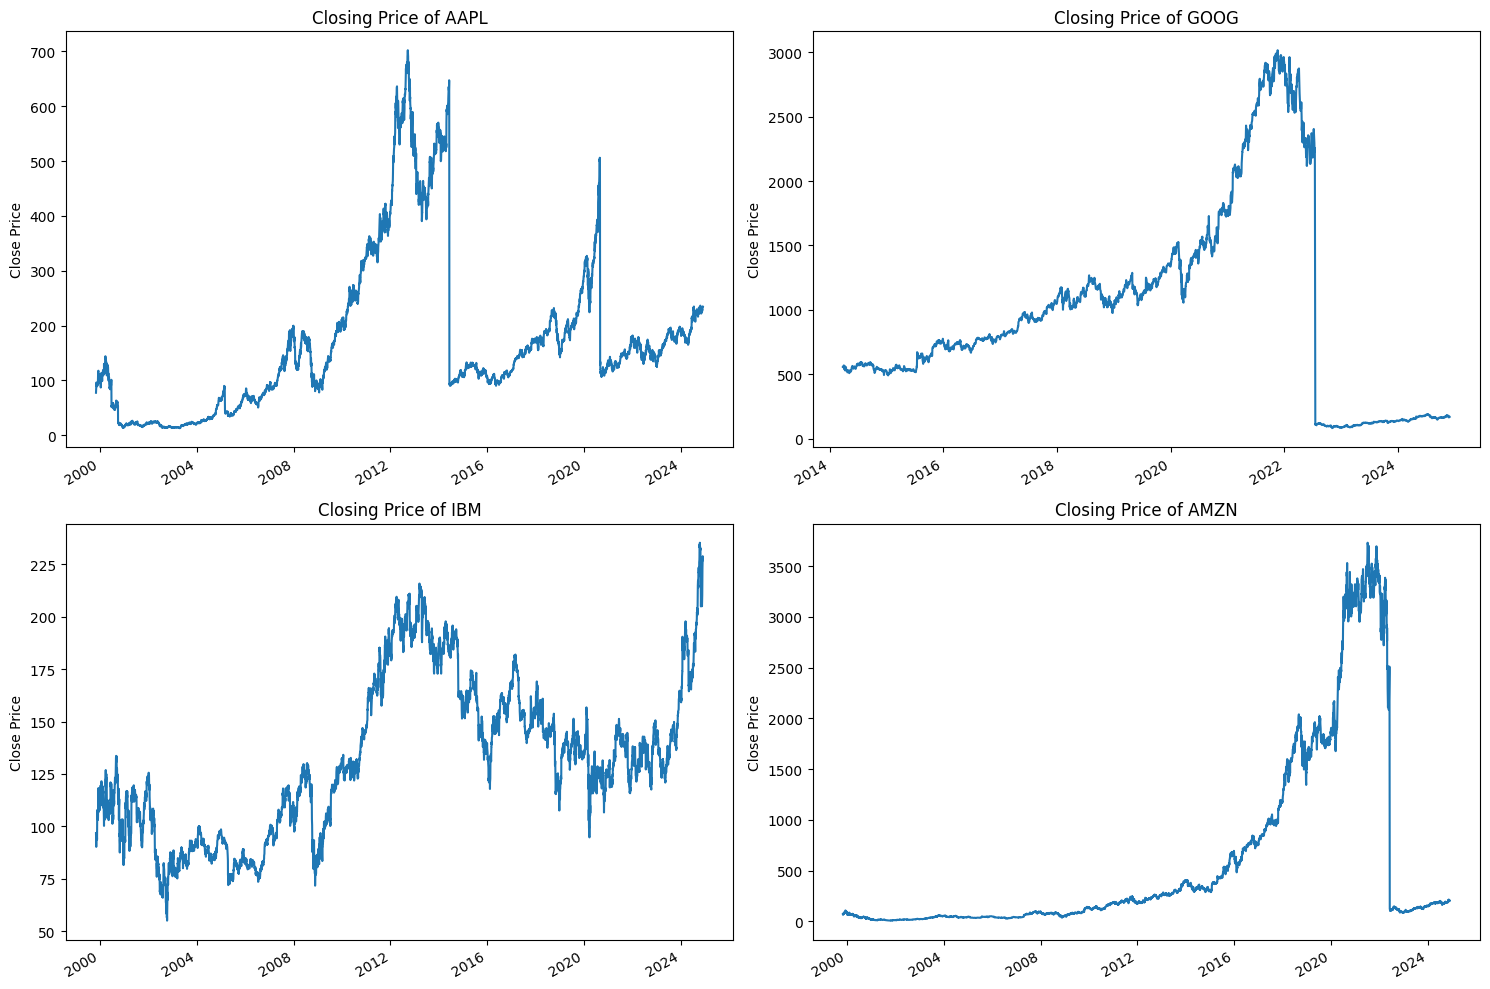

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, symbol in enumerate(tech_list, 1):
    df = dataframes[symbol]
    
    # Plot the closing price
    plt.subplot(2, 2, i)
    df['close'].plot()
    plt.ylabel('Close Price')
    plt.xlabel(None)
    plt.title(f"Closing Price of {symbol}")

plt.tight_layout()
plt.show()

**Volume of Sales**

Volume is the total number of shares traded for a stock in a given time period. It indicates market activity and liquidity:

High Volume: Shows strong interest, often linked to significant price movements.

Low Volume: Indicates less activity, potentially making the stock less liquid.

Volume helps confirm trends, signal reversals, and validate breakouts, making it a key tool in technical analysis.

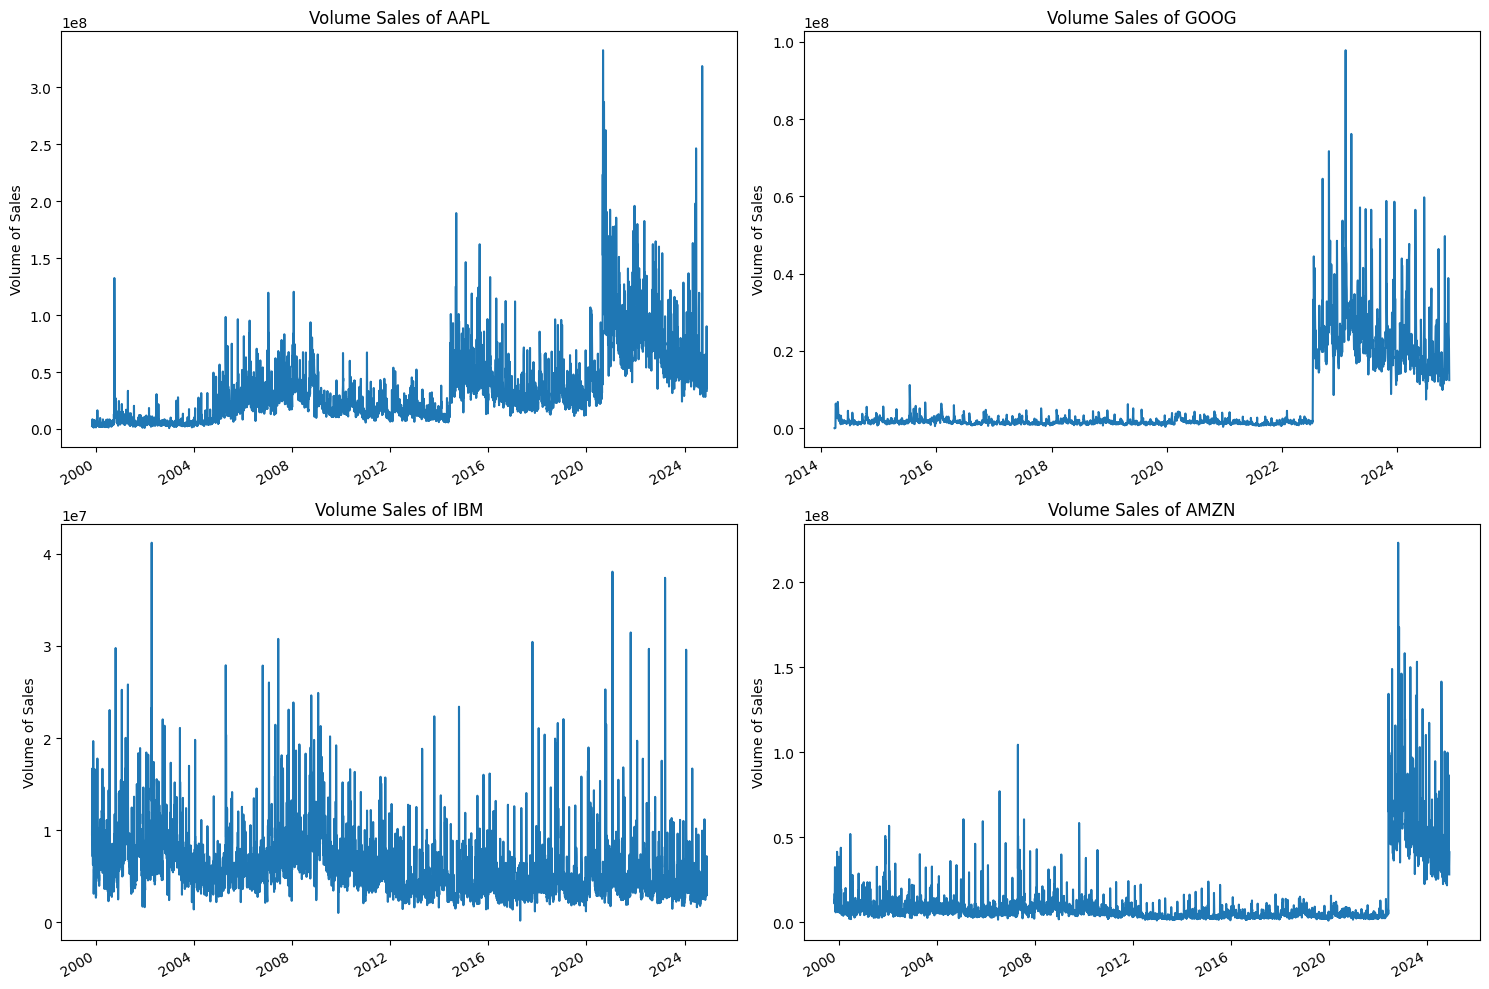

In [71]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, symbol in enumerate(tech_list, 1):
    # Access the DataFrame for the current symbol
    df = dataframes[symbol]
    
    # Plot the closing price
    plt.subplot(2, 2, i)
    df['volume'].plot()
    plt.ylabel('Volume of Sales')
    plt.xlabel(None)
    plt.title(f"Volume Sales of {symbol}")

plt.tight_layout()
plt.show()

Correlation between the four companies

In [72]:
close_prices = pd.DataFrame()

for symbol, df in dataframes.items():
    close_prices[symbol] = df['close']

In [73]:
close_prices

,AAPL,GOOG,IBM,AMZN
2024-11-27,234.93,170.82,226.92,205.74
2024-11-26,235.06,170.62,228.83,207.86
2024-11-25,232.87,169.43,226.13,201.45
2024-11-22,229.87,166.57,222.97,197.12
2024-11-21,228.52,169.24,222.40,198.38
...,...,...,...,...
1999-11-05,88.31,NaN,90.25,64.94
1999-11-04,83.62,NaN,91.56,63.06
1999-11-03,81.50,NaN,94.37,65.81
1999-11-02,80.25,NaN,94.81,66.44


In [74]:
close_prices.dropna(inplace=True)

correlation_matrix = close_prices.corr()

print("Correlation Matrix of Closing Prices:")
print(correlation_matrix)

Correlation Matrix of Closing Prices:
          AAPL      GOOG       IBM      AMZN
AAPL  1.000000  0.002647  0.065250  0.105074
GOOG  0.002647  1.000000 -0.450653  0.905985
IBM   0.065250 -0.450653  1.000000 -0.532924
AMZN  0.105074  0.905985 -0.532924  1.000000


Calculate the daily percentage change for each stock's closing prices.

This measures the relative change from the previous day's price, providing daily returns for analysis.


In [75]:
daily_returns = close_prices.pct_change()

In [76]:
daily_returns

,AAPL,GOOG,IBM,AMZN
2024-11-27,NaN,NaN,NaN,NaN
2024-11-26,0.000553,-0.001171,0.008417,0.010304
2024-11-25,-0.009317,-0.006975,-0.011799,-0.030838
2024-11-22,-0.012883,-0.016880,-0.013974,-0.021494
2024-11-21,-0.005873,0.016029,-0.002556,0.006392
...,...,...,...,...
2014-04-02,0.006979,-0.004809,0.004463,0.024999
2014-04-01,-0.001659,0.000282,0.004908,0.003012
2014-03-31,-0.009065,-0.017967,-0.010334,-0.019315
2014-03-28,0.000224,0.005422,-0.010598,0.005723


In [77]:
daily_returns = daily_returns.dropna()

Text(0.5, 1.0, 'Correlation of stock closing price')

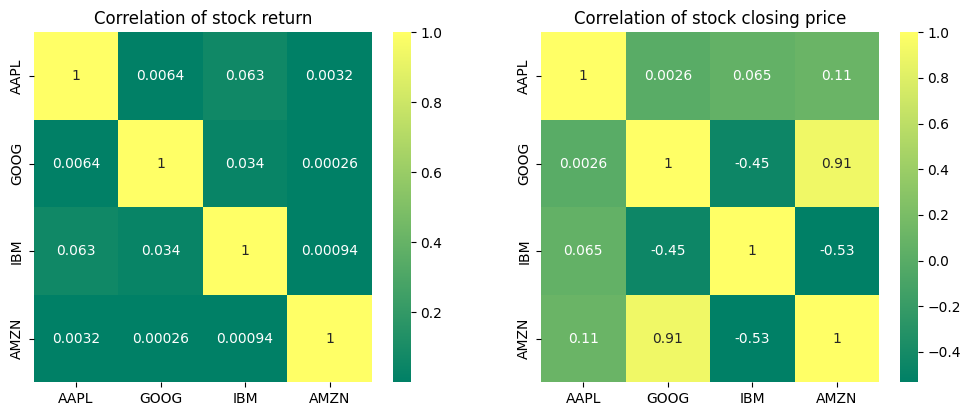

In [78]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(daily_returns.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(close_prices.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

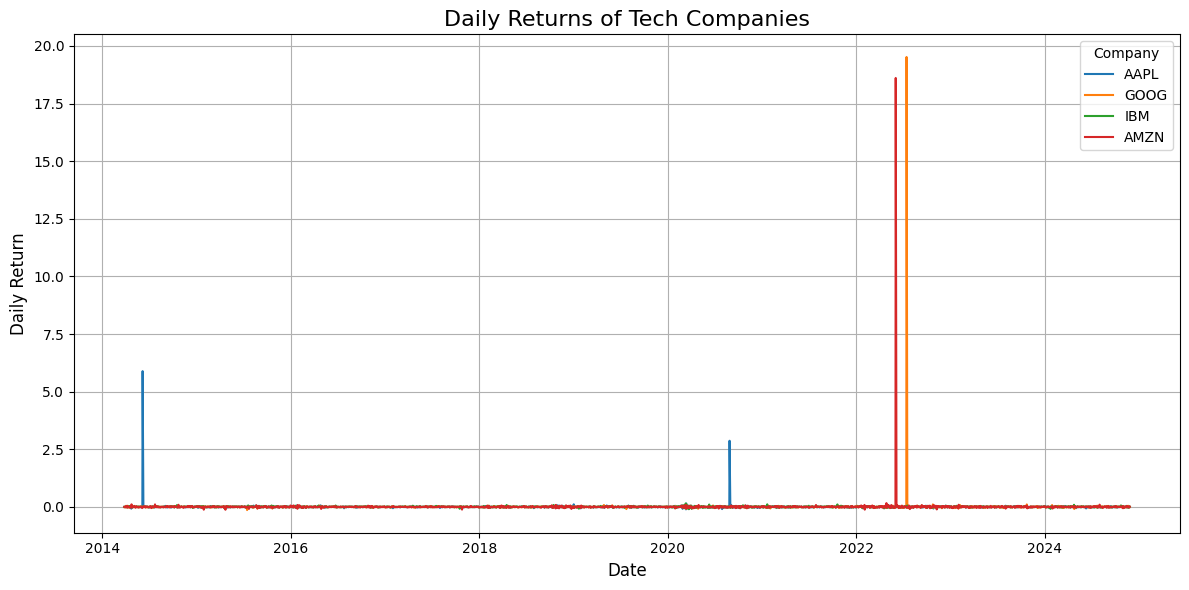

In [79]:
# Plot the daily returns
plt.figure(figsize=(12, 6))
for symbol in daily_returns.columns:
    plt.plot(daily_returns.index, daily_returns[symbol], label=symbol)

# Add labels, legend, and title
plt.title("Daily Returns of Tech Companies", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Return", fontsize=12)
plt.legend(title="Company", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price.

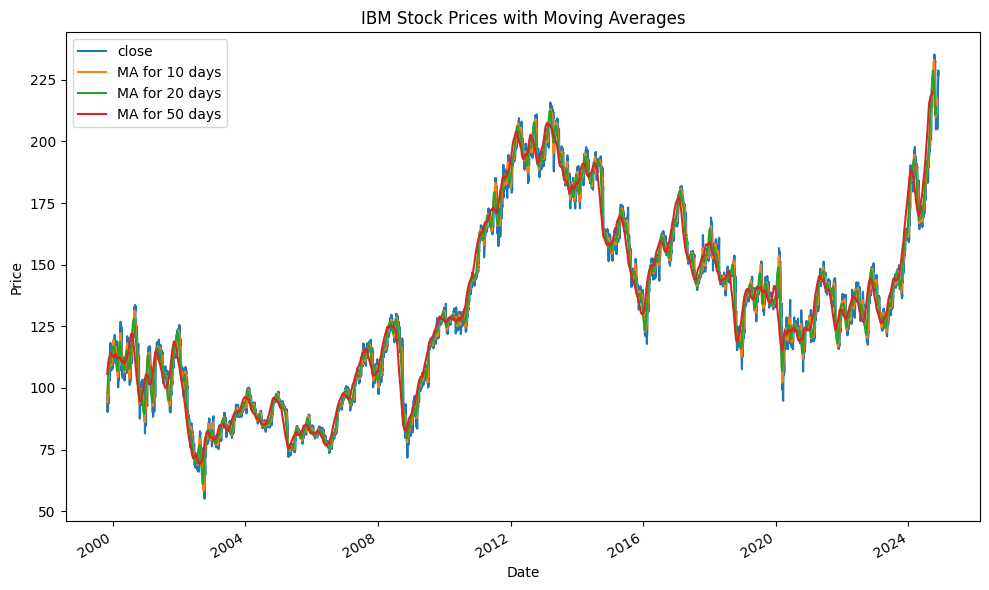

In [80]:
ma_day = [10, 20, 50]

# Calculate moving averages and add them to the IBM DataFrame
for ma in ma_day:
    df = dataframes['IBM']
    column_name = f"MA for {ma} days"
    df[column_name] = df['close'].rolling(ma).mean()

# Plot IBM data with moving averages
fig, ax = plt.subplots(figsize=(10, 6))

dataframes['IBM'][['close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
ax.set_title('IBM Stock Prices with Moving Averages')
ax.set_ylabel('Price')
ax.set_xlabel('Date')

plt.tight_layout()
plt.show()


In [187]:
# Create a new dataframe with only the 'Close column 
data = ibm_data.filter(['close'])

In [188]:
training_data = data[data.index < "2023-01-01"]
testing_data = data[data.index >= "2023-01-01"]

In [189]:
training_data

,close
2022-12-30,140.89
2022-12-29,141.06
2022-12-28,140.02
2022-12-27,142.42
2022-12-23,141.65
...,...
1999-11-05,90.25
1999-11-04,91.56
1999-11-03,94.37
1999-11-02,94.81


In [190]:
testing_data

,close
2024-11-27,226.92
2024-11-26,228.83
2024-11-25,226.13
2024-11-22,222.97
2024-11-21,222.40
...,...
2023-01-09,143.55
2023-01-06,143.70
2023-01-05,141.11
2023-01-04,142.60


In [ ]:
def splitting_data(input_data, scaler=None):
    dataset = input_data.values
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)
    else:
        scaled_data = scaler.transform(dataset)
    
    x_data = []
    y_data = []
    
    for i in range(60, len(scaled_data)):
        x_data.append(scaled_data[i-60:i, 0])
        y_data.append(scaled_data[i, 0])
    
    x_data, y_data = np.array(x_data), np.array(y_data)
    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))
    
    return x_data, y_data, scaler


In [237]:
x_train, y_train = splitting_data(training_data)

In [238]:
x_test, y_test = splitting_data(testing_data)

In [239]:
x_train.shape

(5770, 60, 1)

In [240]:
x_test.shape

(420, 60, 1)

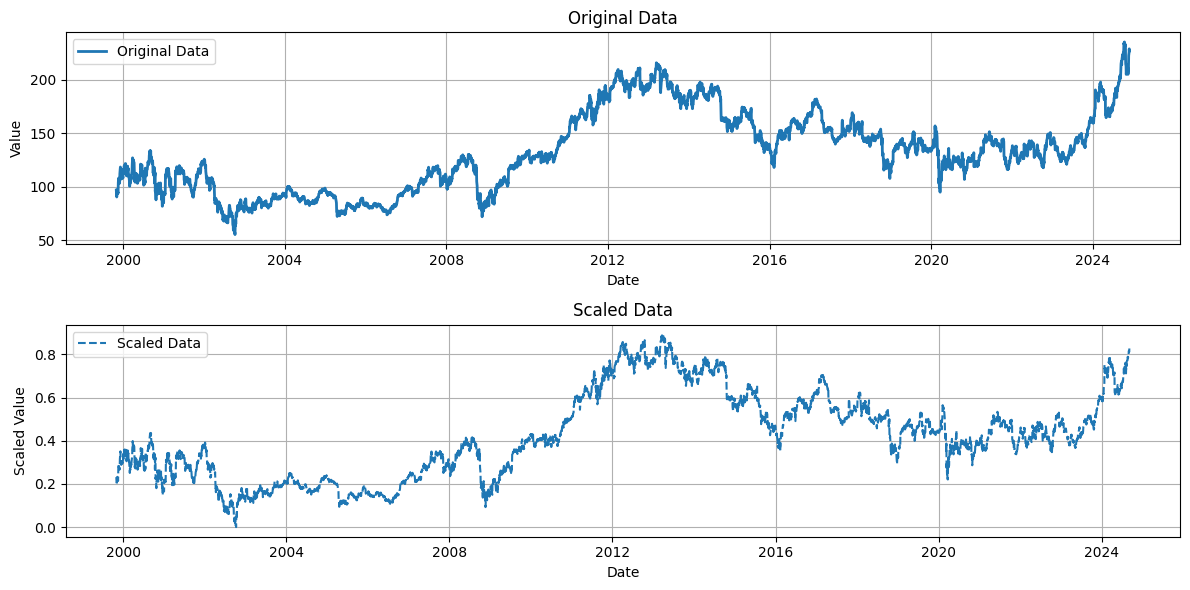

In [ ]:
# Define the function with scaled_data returned
def splitting_data(input_data, scaler=None):
    dataset = input_data.values
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)
    else:
        scaled_data = scaler.transform(dataset)
        
    x_data = []
    y_data = []
    
    for i in range(60, len(scaled_data)):
        x_data.append(scaled_data[i-60:i, 0])
        y_data.append(scaled_data[i, 0])
    
    x_data, y_data = np.array(x_data), np.array(y_data)
    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))
    
    return x_data, y_data, scaled_data, scaler

    
# Use the function
x_data, y_data, scaled_data, scaler = splitting_data(data)

# Ensure correct alignment between df.index and scaled_data
plt.figure(figsize=(12, 6))

# Plot the original data in the first plot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(data.index, data['close'], label="Original Data", linewidth=2)
plt.title("Original Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()

# Plot the scaled data in the second plot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.plot(data.index[60:], scaled_data[60:, 0], label="Scaled Data", linestyle='--')
plt.title("Scaled Data")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid()

# Show both plots
plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()



In [ ]:
x_train, y_train, scaled_data_train, scaler = splitting_data(training_data)

In [268]:
validation_data_len = int(0.2 * len(training_data)) 

validation_data = training_data[-validation_data_len:]

x_val, y_val, scaled_data_val, _ = splitting_data(validation_data, scaler)

In [270]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs of no improvement
    restore_best_weights=True  # Restore the model weights from the best epoch
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),  # Pass validation data here
    batch_size=1,
    epochs=1,  # Set to a higher number of epochs, early stopping will handle stopping
    callbacks=[early_stopping]
)

5770/5770 [==============================] - 107s 18ms/step - loss: 0.0010 - val_loss: 5.9976e-04


In [271]:
x_test, y_test, scaled_data_test, scaler = splitting_data(testing_data)
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test_original) ** 2)))
rmse

14/14 [==============================] - 1s 22ms/step


2.1566997650084048

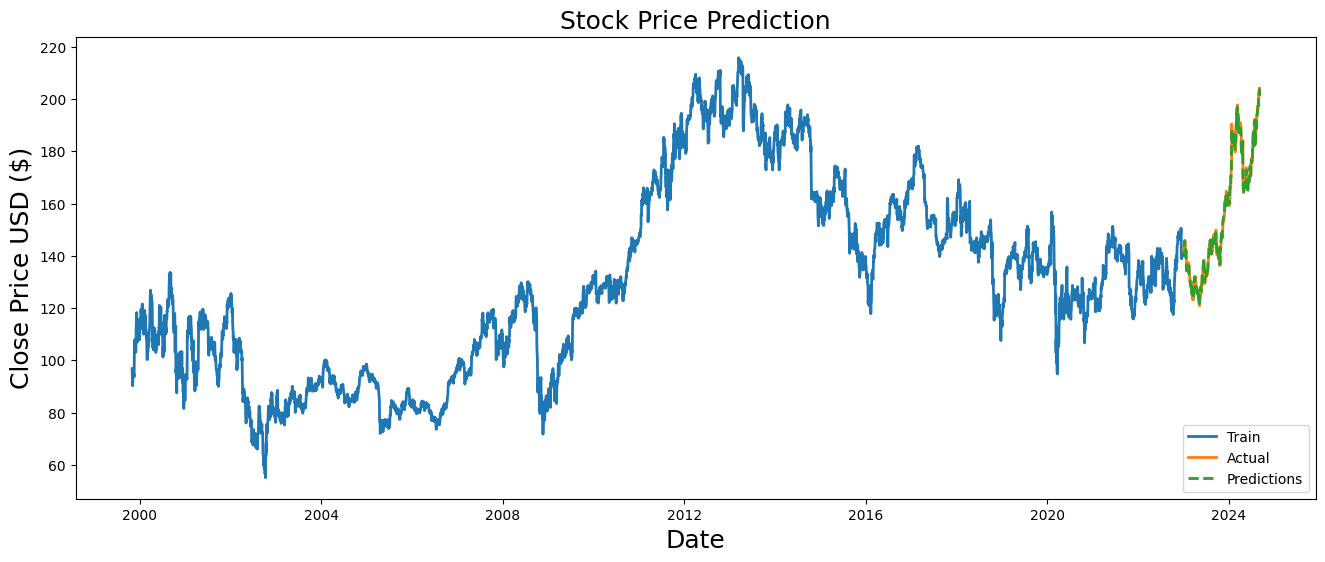

In [272]:
valid = testing_data[60:].copy()  # Slice the data to match the length of predictions
valid['Predictions'] = predictions

# Plot the training data and validation data (predictions vs. actuals)
plt.figure(figsize=(16, 6))
plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# Plotting the actual training data
plt.plot(training_data.index, training_data['close'], label='Train', linewidth=2)

# Plotting the actual and predicted values for validation
plt.plot(valid.index, valid['close'], label='Actual', linewidth=2)
plt.plot(valid.index, valid['Predictions'], label='Predictions', linestyle='--', linewidth=2)

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

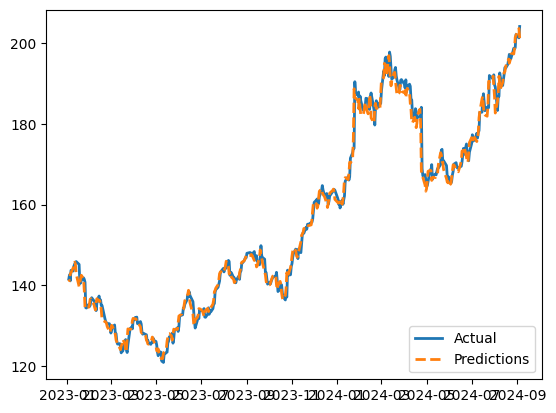

In [273]:
# Plotting the actual and predicted values for validation
plt.plot(valid.index, valid['close'], label='Actual', linewidth=2)
plt.plot(valid.index, valid['Predictions'], label='Predictions', linestyle='--', linewidth=2)

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [266]:
valid

,close,Predictions
2024-09-04,204.11,206.114777
2024-09-03,201.28,207.836960
2024-08-30,202.13,205.614609
2024-08-29,198.90,205.429245
2024-08-28,198.46,202.656921
...,...,...
2023-01-09,143.55,144.554886
2023-01-06,143.70,143.601532
2023-01-05,141.11,143.353928
2023-01-04,142.60,141.784866
